In [56]:
import gym
import numpy as np
import math
import random

from matplotlib import pyplot as plt
from random import randint
from statistics import median, mean
from PIL import Image, ImageDraw
OUT_DIR = 'carport'
env = gym.make('CartPole-v0')
total = []
env._max_episode_steps = 500
for i_episode in range(20):
    ep_reward = 0
    observation = env.reset()
    for t in range(100):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        ep_reward += reward
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    total.append(ep_reward)
env.close()
mean(total)


Episode finished after 36 timesteps
Episode finished after 26 timesteps
Episode finished after 22 timesteps
Episode finished after 36 timesteps
Episode finished after 36 timesteps
Episode finished after 16 timesteps
Episode finished after 15 timesteps
Episode finished after 25 timesteps
Episode finished after 23 timesteps
Episode finished after 17 timesteps
Episode finished after 18 timesteps
Episode finished after 14 timesteps
Episode finished after 10 timesteps
Episode finished after 23 timesteps
Episode finished after 14 timesteps
Episode finished after 17 timesteps
Episode finished after 23 timesteps
Episode finished after 28 timesteps
Episode finished after 42 timesteps
Episode finished after 16 timesteps


22.85

In [23]:
env.reset()


def create_data():
    training_data, scores, accepted_scores = [], [], []
    for _ in range(initial_games):
        score = 0
        #Moves from current environment and previous observations
        game_memory, prev_observation = [], []
        for _ in range(goal_steps):
            action = random.randrange(0,2)
            observation, reward, done, info = env.step(action)
            
            if len(prev_observation) > 0:
                game_memory.append([prev_observation, action])
                
            prev_observation = observation
            score += reward
            
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                training_data.append(data)
                    
        env.reset()        
        scores.append(score)
       
    print('Average accepted score:', mean(accepted_scores))
    print('Median accepted score:', median(accepted_scores))
        
    return training_data


def create_initial_pop(pop_size):
    initial_pop = np.random.uniform(low = -3.0, high = 3.0, size = pop_size)
    print('Initial Population:\n{}'.format(initial_pop))
    return initial_pop

def sigmoid(z):
    return 1/(1+np.exp(-z))

def predict(X):
    pred = np.empty((X.shape[0], 1))
    for i in range(X.shape[0]):
        if X[i] >= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
    return pred


def cal_fitness(population, X, y, pop_size):
    fitness = np.empty((pop_size[0], 1))
    for i in range(pop_size[0]):
        hx  = X@(population[i]).T
        fitness[i][0] = np.sum(hx)
    return fitness

def selection(population, fitness, num_parents):
    fitness = list(fitness)
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

def crossover(parents, num_offsprings):
    offsprings = np.empty((num_offsprings, parents.shape[1]))
    crossover_point = int(parents.shape[1]/2)
    crossover_rate = 0.8
    i=0
    while (parents.shape[0] < num_offsprings):
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        x = random.random()
        if x > crossover_rate:
            continue
        parent1_index = i%parents.shape[0]
        parent2_index = (i+1)%parents.shape[0]
        offsprings[i,0:crossover_point] = parents[parent1_index,0:crossover_point]
        offsprings[i,crossover_point:] = parents[parent2_index,crossover_point:]
        i=+1
    return offsprings    



def mutation(offsprings):
    mutants = np.empty((offsprings.shape))
    mutation_rate = 0.4
    for i in range(mutants.shape[0]):
        random_value = random.random()
        mutants[i,:] = offsprings[i,:]
        if random_value > mutation_rate:
            continue
        int_random_value = randint(0,offsprings.shape[1]-1)    
        mutants[i,int_random_value] += np.random.uniform(-1.0, 1.0, 1)
        
    return mutants



In [24]:
goal_steps = 200
score_requirement = 80
initial_games = 10000

def GA_model(training_data):
    X = np.array([i[0] for i in training_data])
    y = np.array([i[1] for i in training_data]).reshape(-1, 1)
    fitness_history, weights = [], []
    num_solutions = 8
    pop_size = (num_solutions, X.shape[1])
    num_parents = int(pop_size[0]/2)
    num_offsprings = pop_size[0] - num_parents 
    num_generations = 60
    
    population = create_initial_pop(pop_size)
    
    for i in range(num_generations):
        fitness = cal_fitness(population, X, y, pop_size)
        fitness_history.append(fitness)
        parents = selection(population, fitness, num_parents)
        offsprings = crossover(parents, num_offsprings)
        mutants = mutation(offsprings)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = mutants
    
    fitness_last_gen = cal_fitness(population, X, y, pop_size)
    max_fitness = np.where(fitness_last_gen == np.max(fitness_last_gen))
    weights.append(population[max_fitness[0][0],:])
    return weights, fitness_history, num_generations

def GA_model_predict(test_data, weights):
    hx = sigmoid(test_data@(weights).T)
    pred = predict(hx)
    pred = pred.astype(int)
    return pred[0][0]

training_data = create_data()
weights, fitness_history, num_generations = GA_model(training_data)
print('Weights: {}'.format(weights))
weights = np.asarray(weights)

Average accepted score: 92.12
Median accepted score: 88.0
Initial Population:
[[ 0.41068937 -0.27976482 -0.15391663 -2.91487676]
 [-2.8605286  -2.66746106 -0.76405475 -1.45145054]
 [ 0.82435802  1.89543309 -0.32304383  2.83740602]
 [ 1.45700607  0.25089133  2.5904211  -0.39706641]
 [ 2.2595193   0.1345191  -0.67734506 -1.66613967]
 [-2.80304822 -1.25565478  2.31624809  0.09390701]
 [ 0.92765406 -0.14776319 -1.92130352 -0.50077891]
 [ 2.27486758 -0.38877767  1.5274841  -1.02836451]]
Weights: [array([ 6.33311467,  1.09518045, -1.60699212, -4.32783971])]


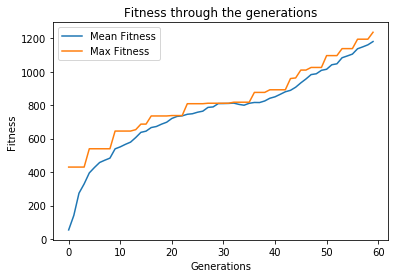

In [25]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

In [26]:
scores, choices = [], []
for each_game in range(10):
    score = 0
    game_memory, prev_obs = [], []
    env.reset()
    for _ in range(500):
        env.render()
        if len(prev_obs) == 0:
            action = random.randrange(0,2)
        else:
            action = GA_model_predict(prev_obs, weights)
        choices.append(action)    
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score += reward
        if done:
            break
    scores.append(score)        
env.close()
print('Average Score:',print('Average Score:',np.mean(scores)))
print(score_requirement)
print(scores)

Average Score: 96.3
Average Score: None
80
[43.0, 193.0, 117.0, 99.0, 143.0, 60.0, 61.0, 92.0, 91.0, 64.0]


In [47]:
env.close()

In [69]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 500
ind = env.observation_space.shape[0]
adim = env.action_space.n


award_set =[]
test_run = 15
best_gen =[]

def softmax(x):
    x = np.exp(x)/np.sum(np.exp(x))
    return x

def lrelu(x):
    alpha=0.2
    return relu(x)-alpha*relu(-x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

# Function generate initial set of weights and bias
def intial_gen(test_run):
    input_weight = []
    input_bias = []

    hidden_weight = []
    out_weight = [] 

    in_node = 4   # 4,2 combination good 
    hid_node = 3

    for i in range(test_run):
        in_w = np.random.rand(ind,in_node)
        input_weight.append(in_w)

        in_b = np.random.rand((in_node))
        input_bias.append(in_b)

        hid_w = np.random.rand(in_node,hid_node)
        hidden_weight.append(hid_w)


        out_w = np.random.rand(hid_node, adim)
        out_weight.append(out_w)

    generation = [input_weight, input_bias, hidden_weight, out_weight]
    return generation



# creat a neural network 
def nn(obs,in_w,in_b,hid_w,out_w):

    obs = obs/max(np.max(np.linalg.norm(obs)),1) 

    Ain = relu(np.dot(obs,in_w)+in_b.T)
    
    Ahid = relu(np.dot(Ain,hid_w))
    lhid = np.dot(Ahid,out_w)
    
    out_put = relu(lhid)
    out_put = softmax(out_put)
    out_put = out_put.argsort().reshape(1,adim)
    act = out_put[0][0] #index of discrete action
    return act

def run_env(env,in_w,in_b,hid_w,out_w):
    obs = env.reset()
    award = 0
    for t in range(300):
        env.render()
        action = nn(obs,in_w,in_b,hid_w,out_w)
        obs, reward, done, info = env.step(action)
        award += reward 
        if done:
            break
    return award

#Run environment randomly 
def rand_run(env,test_run):
    award_set = []
    generations = intial_gen(test_run)

    for episode in range(test_run):
        in_w  = generations[0][episode]
        in_b = generations[1][episode]
        hid_w =  generations[2][episode]
        out_w =  generations[3][episode]
        award = run_env(env,in_w,in_b,hid_w,out_w)
        award_set = np.append(award_set,award)
    gen_award = [generations, award_set]
    return gen_award  


def mutation(new_dna):

    j = np.random.randint(0,len(new_dna))
    if ( 0 <j < 10): # controlling rate of amount mutation
        for ix in range(j):
            n = np.random.randint(0,len(new_dna)) #random postion for mutation
            new_dna[n] = new_dna[n] + np.random.rand()

    mut_dna = new_dna

    return mut_dna

def crossover(Dna_list):
    newDNA_list = []
    newDNA_list.append(Dna_list[0])
    newDNA_list.append(Dna_list[1]) 
    
    for l in range(10):  # generation after crassover
        j = np.random.randint(0,len(Dna_list[0]))
        new_dna = np.append(Dna_list[0][:j], Dna_list[1][j:])

        mut_dna = mutation(new_dna)
        newDNA_list.append(mut_dna)

    return newDNA_list

#Generate new set of weigts and bias from the best previous weights and bias

def reproduce(award_set, generations):

    good_award_idx = award_set.argsort()[-2:][::-1] # here only best 2 are selected 
    good_generation = []
    DNA_list = []

    new_input_weight = []
    new_input_bias = []

    new_hidden_weight = []

    new_output_weight =[]

    new_award_set = []

    
    #Extraction of all weight info into a single sequence
    for index in good_award_idx:

        w1 = generations[0][index]
        dna_in_w = w1.reshape(w1.shape[1],-1)

        b1 = generations[1][index]
        dna_b1 = np.append(dna_in_w, b1)

        w2 = generations[2][index]
        dna_whid = w2.reshape(w2.shape[1],-1)
        dna_w2 = np.append(dna_b1,dna_whid)

        wh = generations[3][index]
        dna = np.append(dna_w2, wh)


        DNA_list.append(dna) # make 2 dna for good gerneration

    newDNA_list = crossover(DNA_list)

    for newdna in newDNA_list: # collection of weights from dna info
        newdna_in_w1 = np.array(newdna[:generations[0][0].size]) 
        new_in_w = np.reshape(newdna_in_w1, (-1,generations[0][0].shape[1]))
        new_input_weight.append(new_in_w)

        new_in_b = np.array([newdna[newdna_in_w1.size:newdna_in_w1.size+generations[1][0].size]]).T #bias
        new_input_bias.append(new_in_b)

        sh = newdna_in_w1.size + new_in_b.size
        newdna_in_w2 = np.array([newdna[sh:sh+generations[2][0].size]])
        new_hid_w = np.reshape(newdna_in_w2, (-1,generations[2][0].shape[1]))
        new_hidden_weight.append(new_hid_w)

        sl = newdna_in_w1.size + new_in_b.size + newdna_in_w2.size
        new_out_w   = np.array([newdna[sl:]]).T
        new_out_w = np.reshape(new_out_w, (-1,generations[3][0].shape[1]))
        new_output_weight.append(new_out_w)

        new_award = run_env(env, new_in_w, new_in_b, new_hid_w, new_out_w) #bias
        new_award_set = np.append(new_award_set,new_award)

    new_generation = [new_input_weight,new_input_bias,new_hidden_weight,new_output_weight]

    return new_generation, new_award_set


In [72]:
def evolution(env,test_run,n_of_generations):
    gen_award = rand_run(env, test_run)

    current_gens = gen_award[0] 
    current_award_set = gen_award[1]
    best_gen =[]
    A =[]
    for n in range(n_of_generations):
        new_generation, new_award_set = reproduce(current_award_set, current_gens)
        current_gens = new_generation
        current_award_set = new_award_set
        avg = np.average(current_award_set)
        if avg > 200:
            best_gen = np.array([current_gens[0][0],current_gens[1][0],current_gens[2][0],current_gens[3][0]])
            np.save("newtest", best_gen)
        a = np.amax(current_award_set)
        print("generation: {}, score: {}".format(n+1, a))
        A = np.append(A, a)
    Best_award = np.amax(A)


    plt.plot(A)
    plt.xlabel('generations')
    plt.ylabel('score')
    plt.grid()

    print('Average accepted score:',mean(A))
    print('Median score for accepted scores:',median(A))
    return plt.show()


generation: 1, score: 27.0
generation: 2, score: 71.0
generation: 3, score: 35.0
generation: 4, score: 61.0
generation: 5, score: 124.0
generation: 6, score: 252.0
generation: 7, score: 145.0
generation: 8, score: 199.0
generation: 9, score: 257.0
generation: 10, score: 183.0
Average accepted score: 135.4
Median score for accepted scores: 134.5


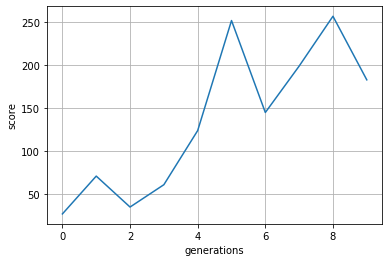

In [73]:
n_of_generations = 10
env.reset()
evolution(env, test_run, n_of_generations)
env.close()

In [74]:
param = np.load("newtest.npy",allow_pickle=True)


in_w = param[0]
in_b = param[1]
hid_w= param[2]
out_w= param[3]


def test_run_env(env,in_w,in_b,hid_w,out_w):
    obs = env.reset()
    award = 0
    for t in range(5000):
        env.render() #thia slows the process
        action = nn(obs,in_w,in_b,hid_w,out_w)
        obs, reward, done, info = env.step(action)
        award += reward
        if done:
            break
    return award

print(test_run_env(env, in_w, in_b, hid_w,out_w))
env.close()

500.0


500.0
